# Example of usual workflow
 Goal is to calculate average NDVI in a forest over time
 - one polygon
 - one image collection
 
### Earth Engine:
1. Import data
2. Functions to - remove clouds (pixel and percent)
                - rename bands
                - add indicies
3. Apply functions - filter by date
                   - aoi
                   - functions from step 2
4. Calculate statistics over aoi
5. Export csv

### Jupyter:
1. Import necessary modules
2. Import data, this process - filters clouds
                             - bands are already named consistently
3. Calculate indices
4. Calculate statistics over aoi - plot
                                 - save as csv

### 1. Import modules

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

from datacube.utils import geometry # needed to turn shapefile into queriable geometry
import rasterio
from rasterio import features # needed to convert polygon into raster for masking

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
#import dea_plotting
from dea_plotting import display_map
#from dea_plotting import rgb

In [2]:
dc = datacube.Datacube()

### 2. Import data

#### Shapefile

Sort out the shapefile first so that it can be used to load the satellite data

iloc help https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/#iloc-selection
- if using iloc to select one row (e.g. iloc[1]) it will return a pandas series which can't be plotted, 
  use list selection (e.g. iloc[[1]]) to return a pandas dataframe which can be plotted

In [3]:
cd

/home/jovyan


In [4]:
# Loading a shapefile as a geopandas dataframe
bowra = gpd.read_file('./Gabrielle/bowra/bowra.shp')

# # Choosing a row based on an attribute
# mac = ramsar.loc[ramsar.RAMSAR_NAM == 'The Macquarie Marshes']#.iloc[[3]]
# #mac = ramsar.loc[ramsar.WETLAND_NA == 'Windella'].head(n=1)
# mac.plot()
# print(mac)
# # Choosing one column from a row based on an attribute
# #test = ramsar.loc[ramsar.RAMSAR_NAM == 'The Macquarie Marshes','geometry']

# #waterbody_polygon = ramsar.loc[ramsar.WETLAND_NA == 'Windella'].head(n=1)
bowra


,osm_id,osm_way_id,name,type,aeroway,amenity,admin_leve,barrier,boundary,building,...,man_made,military,natural,office,place,shop,sport,tourism,other_tags,geometry
0,8210710,None,Bowra Wildlife Sanctuary,boundary,None,None,None,None,protected_area,None,...,None,None,None,None,None,None,None,None,"""access""=>""private"",""iucn_level""=>""VI"",""protec...","MULTIPOLYGON (((145.64311 -28.04800, 145.65092..."
1,8210726,None,Bowra Private Nature Reserve,boundary,None,None,None,None,protected_area,None,...,None,None,None,None,None,None,None,None,"""access""=>""private"",""note2""=>""Bowra Prviate Na...","MULTIPOLYGON (((145.52663 -27.97963, 145.52684..."


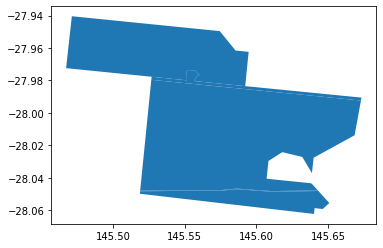

In [5]:
# Re-project polygon to match desired output CRS
# bowra = bowra.to_crs({'init': 'EPSG:3577'})
bowra.plot()

In [19]:
# Use the polygon to create a custom datacube geometry object based on 
# geojson and projection. This is used as in input to the datacube load.
bowra3577 = bowra.to_crs({'init': 'EPSG:3577'})
geom = geometry.Geometry(bowra3577.iloc[0].geometry.__geo_interface__,crs=geometry.CRS('EPSG:3577'))
#geom = geometry.Geometry(mac_albers.geometry.__geo_interface__,crs=geometry.CRS('EPSG:3577')) #removed .iloc[0]
print(geom)

Geometry({'type': 'MultiPolygon', 'coordinates': [(((1322515.9084626366, -3115072.951160218), (1323178.599225171, -3116001.796729265), (1322690.8156893246, -3116368.1172716715), (1322152.7087784056, -3116246.2768168915), (1322065.446130624, -3116641.652211749), (1312571.770222754, -3114479.6154432055), (1310472.261974816, -3114001.783892804), (1312077.2507725873, -3106245.367187405), (1318337.7100333143, -3107559.8674492408), (1318434.9683475196, -3107580.2846274804), (1321622.245812128, -3108249.4172979845), (1326071.1279328528, -3109183.323049809), (1325386.8895026036, -3111524.7217049804), (1322453.1455369797, -3112776.742852145), (1322228.4576137855, -3113822.2017013356), (1321697.9354499604, -3112639.041401314), (1320382.6697035413, -3112164.039692186), (1319387.3768580048, -3112670.9505145233), (1319129.243016953, -3113879.9674149887), (1322080.8539029625, -3114509.002424527), (1322165.302275743, -3114581.5294930274), (1322490.5432838744, -3115037.3988242373), (1322441.2416617183

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Satellite data

Define parameters

In [15]:
# Define the aoi
# lat = (-27.8, -28.0)
# lon = (145.3, 145.7)

bounds = bowra.total_bounds
minx = bounds[0]
maxx = bounds[2]
miny = bounds[1]
maxy = bounds[3]
lon = (minx, maxx)
lat = (miny, maxy)

# Filter date
time = ('2018-12-31', '2019-03-05')

# Choose products to load
# Here, the Sentinel-2A and Sentinel-2B products are chosen
products = ['s2a_ard_granule', 's2b_ard_granule']

In [16]:
# Check location
display_map(x=lon, y=lat)

Create the query

In [17]:
# Specify the parameters to pass to the load query
query = {
#     "x": lon,
#     "y": lat,
    "geopolygon":geom,
    "time": time,
    "measurements": [
        "nbart_red",  # Red band
        "nbart_green",  # Green band
        "nbart_blue",  # Blue band
        "nbart_nir_1",  # Near-infrared band
#         "fmask"  # Cloud masking band
    ],
    "output_crs": 'EPSG:3577',
    "resolution": (-10, 10)
}

Import the data

In [18]:
# Load the data
ds_s2 = load_ard(dc, products=products, min_gooddata=0.1, **query)

Finding datasets
    s2a_ard_granule


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [ ]:
ds_s2.isel(time=0).nbart_red.plot()

### 3. Calculate indices

In [ ]:
ds_s2['ndvi'] = (ds_s2.nbart_nir_1 - ds_s2.nbart_red) / (ds_s2.nbart_nir_1 + ds_s2.nbart_red)

In [ ]:
ds_s2.ndvi.isel(time=0).plot()

In [ ]:
ndvi = ds_s2.ndvi

### 4. Calculate statistics

Mask area outside of polygon

In [ ]:
mask = rasterio.features.rasterize(shapes=[(bowra3577.iloc[0].geometry, 1)],
                                   out_shape=(ds_s2.dims['y'], ds_s2.dims['x']),
                                   transform=ds_s2.geobox.transform)

# Apply raster mask to dataset. This will automatically apply the mask to 
# all timesteps and bands in the dataset.
ndvi_masked = ndvi.where(mask)

# Plot a single timestep in RGB to verify that data outside the polygon has been masked out
ndvi_masked.isel(time=0).plot()

Export inundation metrics

In [ ]:
# Calculate total, inundated, dry and NA stats across the timeseries
mean = ndvi_masked.mean(dim=['x', 'y'])

# Add to a single dataframe ready to be written out as a CSV with time as an index
mean_df = pd.DataFrame(data={'ndwi': mean}, index=ndvi.time.values)

# Write to file
mean_df.to_csv(f'ndvi_mean_{time[0]}-{time[1]}.csv', index_label='time')

# Preview data
mean_df.head()

In [ ]:
mean_df.plot()

Areas (rather than mean)

In [ ]:


# Calculate total, inundated, dry and NA stats across the timeseries
pxct = mask.sum()  # get total pixels from polygon mask area
pxin = (ndwi_masked.water_index >= water_index_thresh).sum(dim=['x', 'y'])
pxha = (ndwi_masked.water_index < water_index_thresh).sum(dim=['x', 'y'])
pxna = pxct - pxin - pxha  # nodata pixels = total - wet - dry

# Compute areas in hectares by multiplying by square metres and dividing by 10000 for ha
toha = pxct * np.abs(output_res[0] * output_res[1]) / 10000.0
inha = pxin * np.abs(output_res[0] * output_res[1]) / 10000.0
drha = pxha * np.abs(output_res[0] * output_res[1]) / 10000.0
naha = pxna * np.abs(output_res[0] * output_res[1]) / 10000.0

# Add to a single dataframe ready to be written out as a CSV with time as an index
wateranalysis_df = pd.DataFrame(data={'pxct': pxct, 'pxin': pxin, 'pxha': pxha, 'pxna': pxna, 
                                      'toha': toha, 'inha': inha, 'drha': drha, 'naha': naha },
                                index=landsat_masked.time.values)

# Write to file
wateranalysis_df.to_csv(f'rel_indundation_{time_range[0]}-{time_range[1]}.csv', index_label='time')

# Preview data
wateranalysis_df.head()